In [2]:
#puts above directory into the path
import sys
sys.path.append("..")
import vrep

In [3]:
import numpy as np
import time

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class trajectoryGenerator:
    
    #list of start points and end points and corresponding max velocities,
    #period is in how fast the output command is sent to the robot, unit should be same as velocity
    def creatTrajectoryMaxVelocity(self, startPoints, endPoints, maxVelocities, period):
        
        startPoints = np.array(startPoints)
        endPoints = np.array(endPoints)
        maxVelocities = np.array(maxVelocities)
        
        dist = np.abs(endPoints - startPoints)
        
        #cubic spline has maximum velocity at the center (1.5 distance/sample)
        numPoints_list = (np.ceil(1.5*(dist/(period*maxVelocities)))).astype(int)
                        
        trajectory = np.ones((len(startPoints), np.max(numPoints_list)))
        time = np.linspace(0, np.max(numPoints_list)*period, np.max(numPoints_list))
                
        for i in range(0, len(startPoints)):
            trajectory[i, :numPoints_list[i]] = self.createTrajectoryNumPoints(startPoints[i], endPoints[i], numPoints_list[i])
            trajectory[i, numPoints_list[i]:] = endPoints[i]
            
        return trajectory, time
    
    def createTrajectoryNumPoints(self, startPoints, endPoints, num_points):
        
        startPoints = np.array(startPoints)
        endPoints = np.array(endPoints)
        
        #Create smooth function with cubic spline
        # y = -2x^3 + 3x^2
        x = np.linspace(0, 1, num_points)
        y = (-2*x**3 + 3*x**2)
        
        dist = endPoints - startPoints
        if dist.size > 1:
            numDim = len(dist)
        else:
            numDim = 1
            
        trajectory = np.ones((numDim, num_points))
        
        if numDim > 1:
            for i in range(0, numDim):
                trajectory[i, :] = dist[i]*y + startPoints[i]
        else:
            trajectory[0, :] = dist*y + startPoints
            
        return trajectory
        
    def plotTrajectory(self, trajectory, time = None):
        for i in range(0, trajectory.shape[0]):
            if time is not None:
                plt.plot(time, trajectory[i,:])
            else:
                plt.plot(trajectory[i,:])
        plt.show()

In [5]:
class VREP_Environement():
    ''' This object defines a VREP environment '''
    def __init__(self, synchronous = False, dt = 0.05):
        self.dt = dt
        self.synchronous = synchronous
        self.robots_connected = 0
        self.robot_names = []
        self.handles_init = None
        self.clientID = None

        #Close any open connections
        vrep.simxFinish(-1)
        
        #Initiate connection to server
        self.connectToServer()

    def connectToServer(self):
        self.clientID = vrep.simxStart('127.0.0.1', 19997, True, True, 500, 5)
        
        if self.clientID != -1: # if we connected successfully
            print ('Connected to remote API server')
            
        #Setup synchronous mode or not
        if self.synchronous == True:
            print("In synchronous mode")
            vrep.simxSynchronous(self.clientID, True)

    def add_robot(self, robot_class):
        self.robots_connected = self.robots_connected + 1
        
        #Vrep env class stuff
        self.robot_names.append(robot_class.robot_name)
        
        #robot_class stuff
        robot_class.clientID = self.clientID
        robot_class.get_handles()
        
        #Add robot to class attributes
        setattr(self, robot_class.robot_name, robot_class)
        
    def start_simulation(self):
        if self.robots_connected == 0:
            print("no robots connected, simulation not started")
        else:
            # Set up streaming
            print("{} robot(s) connected: {}".format(self.robots_connected, self.robot_names))
            vrep.simxSetFloatingParameter(
                self.clientID,
                vrep.sim_floatparam_simulation_time_step,
                self.dt, # specify a simulation time stept
                vrep.simx_opmode_oneshot)
        
            # Start the simulation
            #vrep.simxStartSimulation(self.clientID,vrep.simx_opmode_blocking) #to increase loop speed mode is changed.
            vrep.simxStartSimulation(self.clientID,vrep.simx_opmode_oneshot_wait)


    def shutdown(self):
        vrep.simxStopSimulation(self.clientID, vrep.simx_opmode_oneshot)
        time.sleep(1)
        vrep.simxFinish(self.clientID)


In [6]:
class VREP_Robot():
    '''This object defines the robots in the environment'''
    def __init__(self, robot_name, handle_names, connection_type = 'nonblocking'):
        self.robot_name = robot_name
        self.handle_names = handle_names
        self.handles = None
        self.num_poses = len(handle_names) 
        self.positions = np.ones([self.num_poses,3]) #xyz
        self.orientations = np.ones([self.num_poses,4]) #xyzw
        self.connection_type = connection_type
        self.clientID = None
        
        #Connection type for object grabbing/setting
        if self.connection_type == 'blocking':
            self.opmode = vrep.simx_opmode_blocking
        elif self.connection_type == 'nonblocking':
            self.opmode = vrep.simx_opmode_oneshot
        
    def get_handles(self):
        self.handles = [vrep.simxGetObjectHandle(self.clientID,
            name, vrep.simx_opmode_blocking)[1] for name in self.handle_names]
        
    def setJointPosition(self, object_name, joint_position):
        #object name is the handle for the joint
        
        if self.clientID == None:
            print("Robot not attached to VREP environment")
        else:
            vrep.simxSetJointPosition(
                self.clientID,
                object_name,
                joint_position,
                operationMode=self.opmode
                )
    
    def getJointPosition(self, object_name):
        #object name is the handle for the joint
        
        if self.clientID == None:
            print("Robot not attached to VREP environment")
        else:
            joint_position = vrep.simxGetJointPosition(
                self.clientID,
                object_name,
                operationMode=self.opmode
                )
        return joint_position
            
    def getJointMatrix(self, object_name):
        #object name is the handle for the joint
    
        if self.clientID == None:
            print("Robot not attached to VREP environment")
        else:
            joint_matrix = vrep.simxGetJointMatrix(
                self.clientID,
                object_name,
                operationMode=self.opmode
                )
        return joint_matrix
        
    def setObjectPosition(self, object_name, cartesian_position, relative2='parent'):
        #Changes what it is relative to
        if relative2 == 'parent':
            relative_handle = vrep.sim_handle_parent
        else:
            relative_handle = self.handles[self.handle_names.index(relative2)]
        
        if self.clientID == None:
            print("Robot not attached to VREP environment")
        else:
            vrep.simxSetObjectPosition(
                self.clientID,
                object_name,
                relative_handle,
                position=cartesian_position,
                operationMode=self.opmode
                )
            
    def setObjectOrientation(self, object_name, orientation, relative2='parent'):
        #Changes what it is relative to
        if relative2 == 'parent':
            relative_handle = vrep.sim_handle_parent
        else:
            relative_handle = self.handles[self.handle_names.index(relative2)]
        
        if self.clientID == None:
            print("Robot not attached to VREP environment")
        else:
            vrep.simxSetObjectOrientation(
                self.clientID,
                object_name,
                relative_handle,
                orientation,
                operationMode = self.opmode
                )
            
    def setObjectQuaternion(self, object_name, quaternion, relative2='parent'):
        #Changes what it is relative to
        if relative2 == 'parent':
            relative_handle = vrep.sim_handle_parent
        else:
            relative_handle = self.handles[self.handle_names.index(relative2)]
        
        if self.clientID == None:
            print("Robot not attached to VREP environment")
        else:
            vrep.simxSetObjectQuaternion(
                self.clientID,
                object_name,
                relative_handle,
                quaternion, #(x, y, z, w)
                operationMode = self.opmode
                )
            
    def getObjectPosition(self, object_name, relative2='parent'):
        #Changes what it is relative to
        if relative2 == 'parent':
            relative_handle = vrep.sim_handle_parent
        else:
            relative_handle = self.handles[self.handle_names.index(relative2)]
        
        if self.clientID == None:
            print("Robot not attached to VREP environment")
        else:
            cartesian_position = vrep.simxGetObjectPosition(
                self.clientID,
                object_name,
                relative_handle,
                operationMode = self.opmode
                )
        return cartesian_position
    
    
    def getObjectOrientation(self, object_name, relative2='parent'):
        #Changes what it is relative to
        if relative2 == 'parent':
            relative_handle = vrep.sim_handle_parent
        else:
            relative_handle = self.handles[self.handle_names.index(relative2)]
            
        if self.clientID == None:
            print("Robot not attached to VREP environment")
        else:
            orientation = vrep.simxGetObjectOrientation(
                self.clientID,
                object_name,
                relative_handle,
                operationMode = self.opmode
                )
        return orientation
    
    
    def getObjectQuaternion(self, object_name, relative2='parent'):
        #Changes what it is relative to
        if relative2 == 'parent':
            relative_handle = vrep.sim_handle_parent
        else:
            relative_handle = self.handles[self.handle_names.index(relative2)]
            
        if self.clientID == None:
            print("Robot not attached to VREP environment")
        else:
            quaternion = vrep.simxGetObjectQuaternion(
                self.clientID,
                object_name,
                relative_handle,
                operationMode = self.opmode
                )
        return quaternion

In [7]:
# http://www.coppeliarobotics.com/helpFiles/en/remoteApiFunctionsPython.htm#simxSetObjectQuaternion

#To use classes above, open vrep scene (robot.ttt) first then you can run code below

# Availalble commands 
# vrep_env.robot.getObjectPosition
# vrep_env.robot.getObjectQuaternion
# vrep_env.robot.setObjectPosition
# vrep_env.robot.setObjectQuaternion
# vrep_env.robot.positions #xyz all positions in robot, dim(num joints/frames, 3)
# vrep_env.robot.orientations #xyzw quaternion i think, all orientations in robot, dim(num joints/frames, 4)
# vrep_env.robot.connection_type
# vrep_env.robot.handle_names
# vrep_env.add_robot() - is used to add robots to the environment, must be done before starting simulation
# vrep_env.start_simulation()
# vrep_env.shutdown() #not working right now

# Each command to the vrep server requires an operation mode (blocking, oneshot, etc...), for setting things up
# use blocking mode. This makes sure things are connected etc before moving forward. Things like getting/setting information
# can be used in async mode. This is vrep_env.robot.connection_type.

In [8]:
vrep_env = VREP_Environement()

#Adding robots to scene
ik_handles = ['ik_joint1', 'ik_joint2', 'ik_joint3', 'ik_joint4', 'ik_joint5', 'ik_joint6', 'ik_joint7', 'ik_ee', 'ik_rf7_static']
vrep_env.add_robot(VREP_Robot('ik_robot', ik_handles))

viz_handles = ['viz_joint1', 'viz_joint2', 'viz_joint3', 'viz_joint4', 'viz_joint5', 'viz_joint6', 'viz_joint7']
vrep_env.add_robot(VREP_Robot('viz_robot', viz_handles))

#Add all robot before starting the simulation - once robots are added start simulation
vrep_env.start_simulation()


Connected to remote API server
2 robot(s) connected: ['ik_robot', 'viz_robot']


In [9]:
#Position is in meters? And orientation is quaternions

#need to get zero position then reference off of that

In [10]:
for i in range(len(ik_handles)-1):
    #these are joint positions in reference to one coordinate frame back
    if(vrep_env.ik_robot.handle_names[i]=='ik_ee'):
        print(vrep_env.ik_robot.getObjectPosition(vrep_env.ik_robot.handles[i], relative2 = 'ik_rf7_static'))
    else:
        print(vrep_env.ik_robot.getObjectPosition(vrep_env.ik_robot.handles[i]))

(1, [0.0, 0.0, 0.0])
(1, [0.0, 0.0, 0.0])
(1, [0.0, 0.0, 0.0])
(1, [0.0, 0.0, 0.0])
(1, [0.0, 0.0, 0.0])
(1, [0.0, 0.0, 0.0])
(1, [0.0, 0.0, 0.0])
(1, [0.0, 0.0, 0.0])


In [11]:
joint_pos_start = np.zeros([7,3])
joint_orientation_start = np.zeros([7,3])

#Run it twice since the first run doesnt get anything
for j in range(2):
    time.sleep(1)
    for i in range(7):
        joint_pos_start[i,:] = np.asarray(vrep_env.viz_robot.getObjectPosition(vrep_env.viz_robot.handles[i])[1]).copy()
        joint_orientation_start[i,:] = np.asarray(vrep_env.viz_robot.getObjectOrientation(vrep_env.viz_robot.handles[i])[1]).copy()

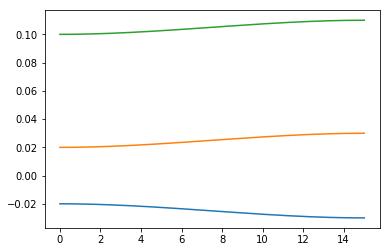

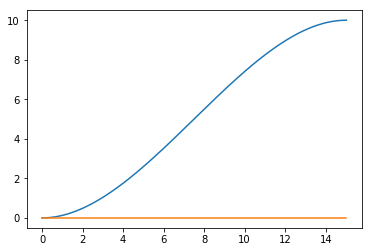

Computed max velocity: 0.000998666074863268
Computed max velocity: 0.000998666074863268
Computed max velocity: 0.0010000011836039861
Computed max velocity: 1.00000118360396
Computed max velocity: 0.0
Computed max velocity: 0.0


In [12]:
#Can set the 6 (x,y,z, rot x, rot y, rot z) dim elements of the EE using Florains trajectory
#Position is in meters and angles are in radians
amount2move = np.array([-0.01, 0.01, 0.01, 10*np.pi/180, 0, 0])
period = 1.0/50.0 # 30 Hz, how fast to feed updates to the robot/simulator whatever you are giving commands to

start_pos = vrep_env.ik_robot.getObjectPosition(vrep_env.ik_robot.handles[7], relative2 = 'ik_rf7_static')[1]
start_orientation = vrep_env.ik_robot.getObjectOrientation(vrep_env.ik_robot.handles[7], relative2 = 'ik_rf7_static')[1]

#concatenate
start = np.array(start_pos + start_orientation)
end = start + amount2move
velocitys = np.array([0.001, 0.001, 0.001, 1*np.pi/180, 1*np.pi/180, 1*np.pi/180]) #m/s and rads/sec

trajPlanner = trajectoryGenerator()
trajectories, times = trajPlanner.creatTrajectoryMaxVelocity(start, end, velocitys, period)

#positions
trajPlanner.plotTrajectory(trajectories[0:3], times)
#angles (degrees)
trajPlanner.plotTrajectory(trajectories[3:-1] * 180/np.pi, times)

for j in range(0, trajectories.shape[0]):
    maxVel = 0
    for i in range(1, trajectories.shape[1]):
        vel = np.abs(trajectories[j,i] - trajectories[j,i-1])/(times[i] - times[i-1])
        if vel > maxVel:
            maxVel = vel
    if j>2:
        maxVel = maxVel * 180/np.pi
        
    print("Computed max velocity: {}".format(maxVel))


In [13]:
np.shape(trajectories)

(6, 751)

## IK Following trajectory, saves data for play back

In [14]:
#Restart to initial coordinates
vrep_env.ik_robot.setObjectOrientation(vrep_env.ik_robot.handles[7], start[3:6], relative2='ik_rf7_static')
vrep_env.ik_robot.setObjectPosition(vrep_env.ik_robot.handles[7], start[0:3], relative2='ik_rf7_static')

In [15]:
#start -> start coordinates
start_time = time.time()
idx = 0
idx_old = -1

#get observations
recorded_pos = []
positions = np.zeros([len(vrep_env.viz_robot.handles), 3])
recorded_orientation = []
orientations = np.zeros([len(vrep_env.viz_robot.handles), 3])
joints = np.zeros([len(vrep_env.viz_robot.handles), 1])
recorded_joints = []

while((time.time() - start_time) <= np.max(times)):
    idx = np.abs((time.time()-start_time) - times).argmin()
    if idx != idx_old:        
        vrep_env.ik_robot.setObjectOrientation(vrep_env.ik_robot.handles[7], trajectories[3:6,idx], relative2='ik_rf7_static')
        vrep_env.ik_robot.setObjectPosition(vrep_env.ik_robot.handles[7], trajectories[0:3,idx], relative2='ik_rf7_static')
        
        for i in range(len(vrep_env.viz_robot.handles)):
            joints[i,:] = np.asarray(vrep_env.ik_robot.getJointPosition(vrep_env.ik_robot.handles[i]))[1]
            
            orientations[i,:] = np.asarray(vrep_env.ik_robot.getObjectOrientation(vrep_env.ik_robot.handles[i])[1])
            positions[i,:] = np.asarray(vrep_env.ik_robot.getObjectPosition(vrep_env.ik_robot.handles[i])[1])
        
        recorded_joints.append(joints.copy())
        recorded_orientation.append(orientations.copy())
        recorded_pos.append(positions.copy())
    idx_old = idx
        

## Playback

In [16]:
recorded_joints = np.asarray(recorded_joints).squeeze()
print(np.shape(recorded_joints))

(751, 7)


In [17]:
# #Restarts to initial conditions
# for i in range(7):
#     vrep_env.viz_robot.setObjectOrientation(vrep_env.viz_robot.handles[i], joint_orientation_start[i,:])
#     vrep_env.viz_robot.setObjectPosition(vrep_env.viz_robot.handles[i], joint_pos_start[i,:])

In [18]:
# start_time = time.time()
# idx = 0
# idx_old = -1

# recorded_joints = np.asarray(recorded_joints).squeeze()

# while((time.time() - start_time) <= np.max(times)):
#     idx = np.abs((time.time()-start_time) - times).argmin()
#     if idx != idx_old:
#         for i in range(7):
#             vrep_env.viz_robot.setJointPosition(vrep_env.viz_robot.handles[i], recorded_joints[idx,i])
            
#             #vrep_env.viz_robot.setObjectOrientation(vrep_env.viz_robot.handles[i], recorded_orientation[idx][i,:])
#             #vrep_env.viz_robot.setObjectPosition(vrep_env.viz_robot.handles[i], recorded_pos[idx][i,:])
#     idx_old = idx


In [19]:
#recorded_joints, single command in a row,
#is meters, meters, radians, radians, radians, radians, meters
recorded_joints[:,[0,1,6]] = recorded_joints[:,[0,1,6]] * 1000

print(np.amax(np.abs(recorded_joints), 0))


[ 9.21705179  9.99999978  0.05236386  0.18352185  0.06405394  0.1977835
 19.99999955]


In [20]:
import sys
sys.path.append("../../kinematics_controls")
from armControl import *
from forwardKinematics import robot_config
from utils.motor_setup import Motors
import signal

In [21]:
pi = np.pi
armKinematics = robot_config()
q = np.array([0., 0., 0., 0., 0., 0., 0.])
#positions = armKinematics.forwardKinPos(q)
#orientation = armKinematics.forwardKinOrientation(q)

armController = remoteRobotArm()
armController.initMotorArmMixing()


def signal_handler(signal, frame):
    motors.tcp_close()
    
signal.signal(signal.SIGINT, signal_handler)
#script_dir = os.path.dirname(__file__)
#results_dir = os.path.join(script_dir, 'Current_data/')
#if not os.path.isdir(results_dir):
#os.makedirs(results_dir)
#Constants
socket_ip = '192.168.1.20'
socket_port = 1122
P = 0
PL = 0
I = 0
IL = 0
D = 0
motors = Motors(P ,PL ,I, IL ,D)

In [22]:
motors.tcp_init(socket_ip, socket_port)
print("Arming motors now...")
motors.arm_motors()

Opening socket at ip: 192.168.1.20 using port: 1122
Arming motors now...
initializing motors to [0 0 0 0 0 0 0 0]
*** C side has an error or needs to be armed ***

Arming motors


In [32]:
q = np.array([0, 0, 0, 0., -0, -0.1, 0])
armController.jointAngleSetpoint = q
armController.updateMotorArmMixing()
print(armController.motorAngleSetpoint)
encoderCounts = armController.motorAngleSetpoint * 479 * 1440 / (2 * pi)
encoderCounts = encoderCounts.astype(int)
encoderCounts[4] = -1 * encoderCounts[4]
encoderCounts[5] = -1 * encoderCounts[5]

print(encoderCounts)

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  7.09530692e-17
 -2.26081780e-16 -8.18181818e-02  1.09090909e-01]
[    0     0     0     0     0  8981 11975]


In [33]:
enc_position = np.zeros(8)
enc_position[1:] = encoderCounts
print(enc_position)
motors.command_motors(enc_position)
time.sleep(1)

[    0.     0.     0.     0.     0.     0.  8981. 11975.]


In [31]:
recorded_joints.shape

(751, 7)

In [26]:
recorded_joints[1:10,:]

array([[-9.01304558,  2.45586294, -0.04697884, -0.11689762,  0.03233242,
         0.10757469, 19.00050603],
       [-9.01304092,  2.45555863, -0.04688197, -0.11703711,  0.03234768,
         0.10783266, 19.00050417],
       [-9.01303161,  2.45550182, -0.04672499, -0.11726886,  0.03237285,
         0.10826041, 19.0005023 ],
       [-9.01302416,  2.45533395, -0.04657327, -0.11749907,  0.03239675,
         0.10868574, 19.00049485],
       [-9.01301485,  2.45531579, -0.04639818, -0.11777479,  0.032426  ,
         0.10919224, 19.00048926],
       [-9.01300833,  2.45532906, -0.04625761, -0.1180028 ,  0.03244898,
         0.10961178, 19.00048554],
       [-9.01300181,  2.45550508, -0.04612189, -0.11823012,  0.03247202,
         0.11002855, 19.00048181],
       [-9.01299343,  2.45625479, -0.0459651 , -0.11850162,  0.03249921,
         0.11052527, 19.00049299],
       [-9.01298784,  2.45661288, -0.04583926, -0.11872653,  0.03252111,
         0.11093653, 19.00047809]])

In [27]:
start_time = time.time()
idx = 0
idx_old = -1

#recorded_joints = recorded_joints[1:, :]
#recorded_joints[:, :] = recorded_joints[:, :] - recorded_joints[1, :]
while((time.time() - start_time) <= np.max(times)):
    idx = np.abs((time.time()-start_time) - times).argmin()
    if idx != idx_old:
        q = recorded_joints[idx, :]
        armController.jointAngleSetpoint = q
        armController.updateMotorArmMixing()
        print(armController.motorAngleSetpoint)
        encoderCounts = armController.motorAngleSetpoint * 479 * 1440 / (2 * pi)
        encoderCounts = encoderCounts.astype(int)
        encoderCounts[4] = -1 * encoderCounts[4]
        encoderCounts[5] = -1 * encoderCounts[5]
        enc_position = np.zeros(8)
        enc_position[1:] = encoderCounts
        #print(enc_position)
        motors.command_motors(enc_position)

    idx_old = idx

[0. 0. 0. 0. 0. 0. 0.]
[-1.13261271  0.30861284 -0.02348942 -0.14877879  0.1696548   0.21354978
  0.95532579]
[-1.13261213  0.3085746  -0.02344099 -0.14895632  0.16982685  0.21389102
  0.95496248]
[-1.13261096  0.30856746 -0.0233625  -0.14925128  0.17011247  0.21445712
  0.95435996]
[-1.13261002  0.30854636 -0.02328664 -0.14954427  0.17039475  0.21501888
  0.95376121]
[-1.13260885  0.30854408 -0.02319909 -0.14989519  0.17073365  0.21568983
  0.95304716]
[-1.13260803  0.30854575 -0.0231288  -0.15018538  0.17101233  0.21624423
  0.95245661]
[-1.13260721  0.30856787 -0.02306094 -0.1504747   0.17129034  0.21679582
  0.95186941]
[-1.13260616  0.30866208 -0.02298255 -0.15082024  0.17162195  0.21745349
  0.95117036]
[-1.13260546  0.30870708 -0.02291963 -0.15110649  0.17189584  0.2179976
  0.95059037]
[-1.13260499  0.30881299 -0.02285887 -0.15139187  0.17216916  0.21853904
  0.95001486]
[-1.13260393  0.30891692 -0.0227886  -0.15173181  0.17249318  0.21918352
  0.94932894]
[-1.13260323  0.30904

[-1.13300115  0.37814144 -0.02146742 -0.17353315  0.19375718  0.25880626
  0.90783353]
[-1.1330091   0.3795306  -0.02147408 -0.17374104  0.1939732   0.25917024
  0.90746266]
[-1.13301753  0.38089313 -0.0214809  -0.17394827  0.19418856  0.25953286
  0.90709258]
[-1.13302619  0.38233054 -0.02148858 -0.17419145  0.19443545  0.2599605
  0.90665334]
[-1.1330345   0.38378219 -0.02149573 -0.17439782  0.19465102  0.26032109
  0.90628757]
[-1.13304304  0.38520804 -0.02150371 -0.17463914  0.19489621  0.26074526
  0.90585103]
[-1.13305241  0.38664942 -0.02151133 -0.17484419  0.1951115   0.26110364
  0.90548708]
[-1.13306107  0.38812159 -0.02151971 -0.17508442  0.19535667  0.2615253
  0.90505492]
[-1.13306996  0.38959826 -0.02152738 -0.17528915  0.19557048  0.26188061
  0.90469438]
[-1.13307886  0.39108786 -0.02153558 -0.17549247  0.19578516  0.26223582
  0.90433391]
[-1.13308822  0.39258197 -0.02154391 -0.17569606  0.19599996  0.26259011
  0.90397508]
[-1.13309723  0.39407683 -0.02155355 -0.17593

[-1.13415474  0.56727697 -0.02283237 -0.19358358  0.21588238  0.29306996
  0.87376447]
[-1.13416949  0.56965544 -0.0228539  -0.19379388  0.21612267  0.29342237
  0.8734198 ]
[-1.13418377  0.57201536 -0.02287246 -0.1939764   0.21634034  0.29372514
  0.87312937]
[-1.13419875  0.57437751 -0.0228913  -0.19415915  0.21655804  0.29402764
  0.87283934]
[-1.13421326  0.57681561 -0.02291343 -0.19436915  0.21679887  0.29437941
  0.87249689]
[-1.13422777  0.57922819 -0.02293527 -0.19457877  0.21703952  0.29473061
  0.87215362]
[-1.13424287  0.58160561 -0.02295421 -0.19476097  0.21725665  0.29503179
  0.87186539]
[-1.13425785  0.58403833 -0.02297025 -0.19491586  0.21745271  0.29528481
  0.87162935]
[-1.13427271  0.58648965 -0.02299582 -0.19515326  0.21771663  0.29568447
  0.87123542]
[-1.13428769  0.58888152 -0.02301208 -0.195308    0.21791243  0.29593685
  0.87099988]
[-1.13430244  0.59133554 -0.02303765 -0.19554484  0.21817586  0.29633547
  0.87060616]
[-1.1343173   0.59379482 -0.02305709 -0.195

[-1.13578631  0.8338502  -0.02523948 -0.21279025  0.23901296  0.32453797
  0.84383344]
[-1.13580433  0.83681471 -0.02527059 -0.21300348  0.23926673  0.32488507
  0.84350279]
[-1.13582224  0.83974225 -0.02529736 -0.21319062  0.23949997  0.325186
  0.84322214]
[-1.13584026  0.84273959 -0.02532868 -0.21340428  0.23975568  0.32553431
  0.84289113]
[-1.13585852  0.84568111 -0.0253555  -0.21359151  0.23998838  0.32583492
  0.84261088]
[-1.13587654  0.84866845 -0.02538689 -0.21380553  0.24024374  0.32618295
  0.84227955]
[-1.13589468  0.85163911 -0.02541378 -0.21399266  0.24047689  0.32648394
  0.84199958]
[-1.13591317  0.85457805 -0.02543656 -0.21415437  0.24069105  0.32673976
  0.84176823]
[-1.13593084  0.85760278 -0.0254728  -0.21439464  0.24096629  0.32713396
  0.84138672]
[-1.13594945  0.86059772 -0.02549558 -0.21455609  0.24118023  0.32738972
  0.84115612]
[-1.13596736  0.86360156 -0.02552764 -0.2147704   0.24143609  0.32773856
  0.84082417]
[-1.13598538  0.86656836 -0.02555502 -0.21495

[-1.13779881  1.13375706 -0.02618022 -0.23247551  0.2641429   0.35698406
  0.81490276]
[-1.13787641  1.13479632 -0.02618023 -0.23264115  0.26436672  0.35725415
  0.81515853]
[-1.1379533   1.13580901 -0.02618024 -0.23279317  0.26458059  0.35750031
  0.81542778]
[-1.13802972  1.13681948 -0.02618024 -0.23291768  0.26476963  0.35769585
  0.81575023]
[-1.13810626  1.13782585 -0.02618025 -0.23303113  0.26494916  0.3578712
  0.81609228]
[-1.13818292  1.13981518 -0.02618029 -0.23319569  0.26524309  0.35810186
  0.81689452]
[-1.13825899  1.1398352  -0.02618026 -0.23322507  0.26527978  0.35816173
  0.81683983]
[-1.13833518  1.14082869 -0.02618027 -0.23331085  0.26543547  0.35828659
  0.81723016]
[-1.1384109   1.14181213 -0.02618027 -0.23338102  0.26557775  0.35838293
  0.81764648]
[-1.13848639  1.14278678 -0.02618028 -0.23344079  0.26571109  0.35846029
  0.81807886]
[-1.13856246  1.14473972 -0.02618032 -0.23354072  0.26594885  0.35857231
  0.81899131]
[-1.13863759  1.14474756 -0.02618029 -0.2335

[-1.14511727  1.22062397 -0.02618087 -0.21598417  0.25774116  0.32387098
  0.89695875]
[-1.14519158  1.22144098 -0.02618087 -0.21572249  0.25758871  0.32336433
  0.89794273]
[-1.14526742  1.22227133 -0.02618088 -0.21551457  0.25748299  0.32295699
  0.89882565]
[-1.14534256  1.22310683 -0.02618089 -0.2153087   0.25737848  0.32255268
  0.89970771]
[-1.14541699  1.22391729 -0.0261809  -0.21505412  0.25723224  0.32206059
  0.9006726 ]
[-1.14549201  1.22473758 -0.0261809  -0.21485337  0.25713222  0.32166574
  0.90153737]
[-1.14556726  1.22556407 -0.02618091 -0.21460483  0.25699107  0.3211847
  0.90249764]
[-1.14564368  1.22639793 -0.02618091 -0.21445708  0.25693657  0.32088753
  0.90326312]
[-1.14571718  1.2271947  -0.02618092 -0.21421343  0.25679871  0.32041474
  0.90420026]
[-1.14579325  1.22803406 -0.02618092 -0.21402071  0.25670446  0.32003546
  0.90505654]
[-1.1458678   1.22884253 -0.02618093 -0.21378332  0.25657304  0.319575
  0.90598628]
[-1.14594352  1.22967042 -0.02618094 -0.213596

[-1.15234385  1.25663703 -0.02618146 -0.20497911  0.25461683  0.30133839
  0.94178754]
[-1.15240962  1.25663703 -0.02618147 -0.20494696  0.25464151  0.30125914
  0.941902  ]
[-1.15247574  1.25663703 -0.02618147 -0.20492764  0.25467821  0.30120342
  0.94199153]
[-1.15254093  1.25663703 -0.02618148 -0.20489832  0.25470535  0.30112933
  0.94210045]
[-1.15260659  1.25663703 -0.02618148 -0.20488076  0.25474147  0.30107628
  0.9421863 ]
[-1.15267166  1.25663703 -0.02618149 -0.20487412  0.25478812  0.30104432
  0.94224963]
[-1.15273673  1.25663703 -0.02618149 -0.20484715  0.25481737  0.30097587
  0.94235217]
[-1.15280133  1.25663703 -0.0261815  -0.20483194  0.2548556   0.30092759
  0.94243279]
[-1.152865    1.25663703 -0.0261815  -0.20480728  0.25488532  0.3008628
  0.94253083]
[-1.15292948  1.25663703 -0.02618151 -0.2047935   0.25492428  0.30081782
  0.9426075 ]
[-1.15299292  1.25663703 -0.02618151 -0.20477087  0.25495523  0.30075701
  0.94270095]
[-1.1530567   1.25663703 -0.02618152 -0.2047

[-1.15732538  1.25663703 -0.02618186 -0.20488662  0.25838557  0.2996656
  0.94572642]
[-1.15735569  1.25663703 -0.02618186 -0.20489141  0.25841231  0.29966548
  0.94573911]
[-1.15738565  1.25663703 -0.02618186 -0.20489805  0.25844069  0.29966895
  0.94574791]
[-1.15741502  1.25663703 -0.02618186 -0.20490283  0.25846648  0.29966888
  0.9457601 ]
[-1.15744428  1.25663703 -0.02618187 -0.20490926  0.25849367  0.29967217
  0.94576858]
[-1.15747225  1.25663703 -0.02618187 -0.20491404  0.25851904  0.29967248
  0.94578008]
[-1.15750093  1.25663703 -0.02618187 -0.20492051  0.25854579  0.29967597
  0.94578809]
[-1.15752855  1.25663703 -0.02618187 -0.2049253   0.25857069  0.29967654
  0.94579902]
[-1.15755535  1.25663703 -0.02618188 -0.20493113  0.25859548  0.29967939
  0.94580695]
[-1.15758168  1.25663703 -0.02618188 -0.204936    0.25861946  0.29967998
  0.94581745]
[-1.15760801  1.25663703 -0.02618188 -0.20494186  0.25864436  0.29968339
  0.94582469]
[-1.15763364  1.25663703 -0.02618188 -0.2049

In [ ]:
vrep_env.shutdown()

In [91]:
motors.tcp_close()
